## 1.このSprintについて

Sprintの目的
系列データに関する応用例を学ぶ

どのように学ぶか
公開されているコードを元に学んでいきます。



## 2.機械翻訳

系列データに関する手法の基本的な活用例としては機械翻訳があります。これは系列データを入力し、系列データを出力する Sequence to Sequence の手法によって行えます。

### 【問題1】機械翻訳の実行とコードリーディング

Keras公式のサンプルコードで、短い英語からフランス語への変換を行うものが公開されています。これを動かしてください。


[keras/lstm_seq2seq.py at master · keras-team/keras](https://github.com/keras-team/keras/blob/master/examples/lstm_seq2seq.py)


その上でこのサンプルコードの各部分がどういった役割かを読み取り、まとめてください。以下のようにどこからどこの行が何をしているかを記述してください。

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# カレントディレクトリの変更
import os
os.chdir('/content/drive/My Drive/Sprint24/')

# カレントディレクトリの取得
print(os.getcwd())

/content/drive/My Drive/Sprint24


In [1]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
!nvidia-smi

In [6]:
'''
#Sequence to sequence example in Keras (character-level).
This script demonstrates how to implement a basic character-level
sequence-to-sequence model. We apply it to translating
short English sentences into short French sentences,
character-by-character. Note that it is fairly unusual to
do character-level machine translation, as word-level
models are more common in this domain.
**Summary of the algorithm**
- We start with input sequences from a domain (e.g. English sentences)
    and corresponding target sequences from another domain
    (e.g. French sentences).
- An encoder LSTM turns input sequences to 2 state vectors
    (we keep the last LSTM state and discard the outputs).
- A decoder LSTM is trained to turn the target sequences into
    the same sequence but offset by one timestep in the future,
    a training process called "teacher forcing" in this context.
    It uses as initial state the state vectors from the encoder.
    Effectively, the decoder learns to generate `targets[t+1...]`
    given `targets[...t]`, conditioned on the input sequence.
- In inference mode, when we want to decode unknown input sequences, we:
    - Encode the input sequence into state vectors
    - Start with a target sequence of size 1
        (just the start-of-sequence character)
    - Feed the state vectors and 1-char target sequence
        to the decoder to produce predictions for the next character
    - Sample the next character using these predictions
        (we simply use argmax).
    - Append the sampled character to the target sequence
    - Repeat until we generate the end-of-sequence character or we
        hit the character limit.
**Data download**
[English to French sentence pairs.
](http://www.manythings.org/anki/fra-eng.zip)
[Lots of neat sentence pairs datasets.
](http://www.manythings.org/anki/)
**References**
- [Sequence to Sequence Learning with Neural Networks
   ](https://arxiv.org/abs/1409.3215)
- [Learning Phrase Representations using
    RNN Encoder-Decoder for Statistical Machine Translation
    ](https://arxiv.org/abs/1406.1078)
'''
from __future__ import print_function

from keras.models import Model
from keras.layers import Input, LSTM, Dense
import numpy as np

batch_size = 64  # Batch size for training.
epochs = 100  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 10000  # Number of samples to train on.
# Path to the data txt file on disk.
data_path = 'fra-eng/fra.txt'

# Vectorize the data.
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
with open(data_path, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')
for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text, _ = line.split('\t')
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = '\t' + target_text + '\n'
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

input_token_index = dict(
    [(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict(
    [(char, i) for i, char in enumerate(target_characters)])

encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
    encoder_input_data[i, t + 1:, input_token_index[' ']] = 1.
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.
    decoder_input_data[i, t + 1:, target_token_index[' ']] = 1.
    decoder_target_data[i, t:, target_token_index[' ']] = 1.
# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Run training
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2)
# Save model
model.save('s2s.h5')

# Next: inference mode (sampling).
# Here's the drill:
# 1) encode input and retrieve initial decoder state
# 2) run one step of decoder with this initial state
# and a "start of sequence" token as target.
# Output will be the next target token
# 3) Repeat with the current target token and current states

# Define sampling models
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())


def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index['\t']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence


for seq_index in range(100):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)

Number of samples: 10000
Number of unique input tokens: 71
Number of unique output tokens: 93
Max sequence length for inputs: 15
Max sequence length for outputs: 59
Epoch 1/100
125/125 [==============================] - 2s 17ms/step - loss: 1.1958 - accuracy: 0.7243 - val_loss: 1.0729 - val_accuracy: 0.7008
Epoch 2/100
125/125 [==============================] - 2s 12ms/step - loss: 0.8754 - accuracy: 0.7655 - val_loss: 0.8637 - val_accuracy: 0.7662
Epoch 3/100
125/125 [==============================] - 1s 12ms/step - loss: 0.7056 - accuracy: 0.8031 - val_loss: 0.7410 - val_accuracy: 0.7861
Epoch 4/100
125/125 [==============================] - 1s 12ms/step - loss: 0.6099 - accuracy: 0.8236 - val_loss: 0.6586 - val_accuracy: 0.8080
Epoch 5/100
125/125 [==============================] - 1s 12ms/step - loss: 0.5565 - accuracy: 0.8376 - val_loss: 0.6224 - val_accuracy: 0.8159
Epoch 6/100
125/125 [==============================] - 1s 12ms/step - loss: 0.5182 - accuracy: 0.8479 - val_loss: 0

__《コードリーディング》__

44 ~ 48行目 ライブラリのimport

50 ~ 55行目 ハイパーパラメータの設定

58 ~ 76行目 ファイルを読み込み、1行毎にテキストを取り出し、インプットとターゲットにスプリットしている。

78 ~ 89行目 ソート、単語のサイズ、テキストの最大の長さ等の情報を処理

96 ~ 104行目 エンコーダのインプットデータ、デコーダのインプットデータ、ターゲットデータのnumpyのゼロ配列を準備

119 ~ 149 行目
  - インプットシーケンスを定義して処理
  - エンコーダ出力を廃棄して、状態のみを保持
  - 初期状態としてのエンコーダ状態を使用してデコーダをセットアップ
  - 全体の出力シーケンスと内部状態を返すためにデコーダをセットアップ
  - 訓練モデルの戻り状態は未使用、推論で使用
  - encoder_input_dataとdecoder_input_dataをdecoder_target_dataにするモデルを定義
  - 訓練を実行
  - モデルをセーブ

151 ~ 178行目
  - 推論
  - インプットをエンコードして初期デコーダ状態を取得
  - この初期状態及びターゲットとしてのSOSトークンとともにデコーダのワンステップを実行
  - 出力は次のターゲットトークン(教師強制)
  - 上記ターゲットトークン及び状態の流れを繰り返し
  - サンプルモデルを定義
  - 逆引きトークンインデックスで読解可能なシーケンスをデコード

181 ~ 216行目
  - シーケンスのデコード
  - 状態ベクトルとしてのインプットをエンコード
  - 長さ1の空のターゲットシーケンスを生成
  - スタート文字と共にターゲットシーケンスの最初の文字を配置
  - バッチシーケンス間のループ
  - トークンをサンプル
  - 終了条件：最大の長さかストップ文字の発見
  - ターゲットシーケンスをアップデート
  - 状態をアップデート

219 ~ 226行目
  - シーケンスインデックス
  - デコードを試行するため一つのシーケンスを取る(訓練セットの一部分)
  

## 3.イメージキャプショニング

他の活用例としてイメージキャプショニングがあります。画像に対する説明の文章を推定するタスクです。これは画像を入力し、系列データを出力する Image to Sequence の手法によって行えます。


[pytorch-tutorial/tutorials/03-advanced/image_captioning at master · yunjey/pytorch-tutorial](https://github.com/yunjey/pytorch-tutorial/tree/master/tutorials/03-advanced/image_captioning)


イメージキャプショニングは学習に多くの時間がかかるため、ここでは学習済みの重みが公開されている実装を動かすことにします。Kerasには平易に扱える実装が公開されていないため、今回はPyTorchによる実装を扱います。

### 【問題2】イメージキャプショニングの学習済みモデルの実行 

上記実装において 5. Test the model の項目を実行してください。また、自身で用意した画像に対しても文章を生成してください。これらに対してどういった文章が出力されたかを記録して提出してください。


データセットからの学習は行わず、学習済みの重みをダウンロードして利用します。


注意点として、デフォルトで設定されている重みのファイル名と、ダウンロードできる重みのファイル名は異なっています。ここは書き換える必要があります。

In [7]:
# カレントディレクトリの変更
import os
os.chdir('/content/drive/My Drive/Sprint24/')

# カレントディレクトリの取得
print(os.getcwd())

/content/drive/My Drive/Sprint24


In [8]:
!git clone https://github.com/yunjey/pytorch-tutorial.git

Cloning into 'pytorch-tutorial'...
remote: Enumerating objects: 917, done.
remote: Total 917 (delta 0), reused 0 (delta 0), pack-reused 917
Receiving objects: 100% (917/917), 12.80 MiB | 12.26 MiB/s, done.
Resolving deltas: 100% (491/491), done.


In [23]:
os.chdir('/content/drive/My Drive/Sprint24/pytorch-tutorial/tutorials/03-advanced/image_captioning')
print(os.getcwd())

/content/drive/My Drive/Sprint24/pytorch-tutorial/tutorials/03-advanced/image_captioning


In [24]:
!python sample.py --image='png/example.png'

<start> a group of giraffes standing next to each other . <end>


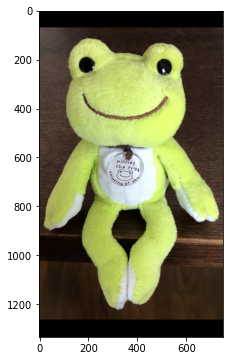

In [31]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

im = Image.open("./png/image.png")
im_list = np.asarray(im)
plt.figure(figsize=(8, 6))
plt.imshow(im_list)
plt.show()

In [25]:
!python sample.py --image='png/image.png'

<start> a teddy bear with a red bow tie on a table . <end>


### 【問題3】Kerasで動かしたい場合はどうするかを調査 

PyTorchによる実装を動かしましたが、何らかの理由からKerasで動かしたい状況が考えられます。どういった手順を踏むことになるか調査し、できるだけ詳しく説明してください。


特に今回はPyTorchのための学習済みの重みをKerasで使えるようにしたいので、その点については必ず触れてください。

参考Qiita：[PyTorchで学習したモデルをTFLiteモデルに変換して使う](https://qiita.com/lain21/items/9f9f9707ebad4bbc627d)

1. PyTorchでモデルを定義して学習
2. 学習済みモデルをONNX形式に変換して保存
3. ONNX形式のモデルをKerasのモデルに変換

《補足》
- PyTorchのモデルはNCHWというchannel_first形式でモデルが定義される。
- TensorFlow/Kerasのデフォルトはchannels_last形式である。
- 参考Github：[ONNX to Keras](https://github.com/nerox8664/onnx2keras)

### 【問題4】（アドバンス課題）コードリーディングと書き換え 

モデル部分はmodel.pyに書かれていますが、Kerasではこのモデルがどのように記述できるかを考え、コーディングしてください。その際機械翻訳のサンプルコードが参考になります。

回答無し

### 【問題5】（アドバンス課題）発展的調査

__《他の言語の翻訳を行う場合は？》__


問題1の実装を使い日本語と英語の翻訳を行いたい場合はどのような手順を踏むか考えてみましょう。


__《機械翻訳の発展的手法にはどのようなものがある？》__


機械翻訳のための発展的手法にはどういったものがあるか調査してみましょう。


__《文章から画像生成するには？》__


イメージキャプショニングとは逆に文章から画像を生成する手法もあります。どういったものがあるか調査してみましょう。

回答無し